<a href="https://colab.research.google.com/github/RainaVardhan/project_voting/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [339]:
! git clone https://github.com/DS3001/project_voting.git

fatal: destination path 'project_voting' already exists and is not an empty directory.


In [ ]:
#cleaned data for county data - get demographics

import pandas as pd
import numpy as np

df = pd.read_csv('/content/project_voting/data/county_data/0002_ds250_20205_county_M.csv', encoding='ISO-8859-1') #asked chat how to fix encoding error
df['U.S. citizen: Born in the US'] = df['AM0KM002']
df['U.S. citizen: Born abroad'] = df['AM0KM004']
df['U.S. citizen: Naturalized'] = df['AM0KM005']
df['Male'] = df['AM8FM002']
df['Female'] = df['AM8FM021']
df['18 to 30 years'] = df['AM8FM009']+df['AM8FM028']
df['35 to 64 years'] = df['AM8FM012']+df['AM8FM031']
df['65 to 74 years'] = df['AM8FM015']+df['AM8FM034']
df['75 years and over'] = df['AM8FM018']+df['AM8FM037']

virginia_county_data = df[df['STATE'] == 'Virginia']

vars_to_keep = ['COUNTY','U.S. citizen: Born in the US', 'U.S. citizen: Born abroad', 'U.S. citizen: Naturalized', 'Male', 'Female', '18 to 30 years', '35 to 64 years', '65 to 74 years', '75 years and over']
county_data = virginia_county_data[vars_to_keep]
# county_data = county_data.drop(virginia_county_data.index[0])
county_data.head()

county_data.isna().sum()
county_data = county_data.dropna()
county_data.isna().sum()
print(county_data.head())



In [ ]:
#cleaned data to get party and total candidate votes 2020

df = pd.read_csv('/content/project_voting/data/voting_VA.csv')
#df.head()

# check for nan values
print(df.isnull().values.any())

# check for possible mistakes
df[df['totalvotes'] == 0]

# split the dataframe into each year
votes_2012 = df[df['year']==2012]
votes_2016 = df[df['year']==2016]
votes_2020 = df[df['year']==2020]

# find out which party got the most votes in each county
winners_2012_idx = votes_2012.groupby('county_name')['candidatevotes'].idxmax() # find maximum number of candidatevotes for county using idxmax
winners_2012 = votes_2012.loc[winners_2012_idx]
winners_2016_idx = votes_2016.groupby('county_name')['candidatevotes'].idxmax()
winners_2016 = votes_2016.loc[winners_2016_idx]
winners_2020_idx = votes_2020.groupby('county_name')['candidatevotes'].idxmax()
winners_2020 = votes_2020.loc[winners_2020_idx]

# combine the dataframes into 1
winners_all = pd.concat([winners_2012,winners_2016,winners_2020])

winners_all

votes_2016[votes_2016['county_name'] == 'BEDFORD']
# the 0 values seems to be an accidental double entry = don't have to clean

In [ ]:
#cleaned data to get district number

df = pd.read_csv('/content/project_voting/data/county_adjacencies.csv')
columns_to_keep = ['County', 'District']
districts = df[columns_to_keep].sort_values(by='District')
districts.to_csv('districts.csv', index=False)
def add_space_before_capitalized(value):
    return value[0] + ''.join(' ' + char if char.isupper() else char for char in value[1:])

# Apply the function to the 'variable' column
districts['County'] = districts['County'].apply(add_space_before_capitalized).str.upper()

print(districts)

<ipython-input-372-adfeed2dc246>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData.dropna(inplace=True)


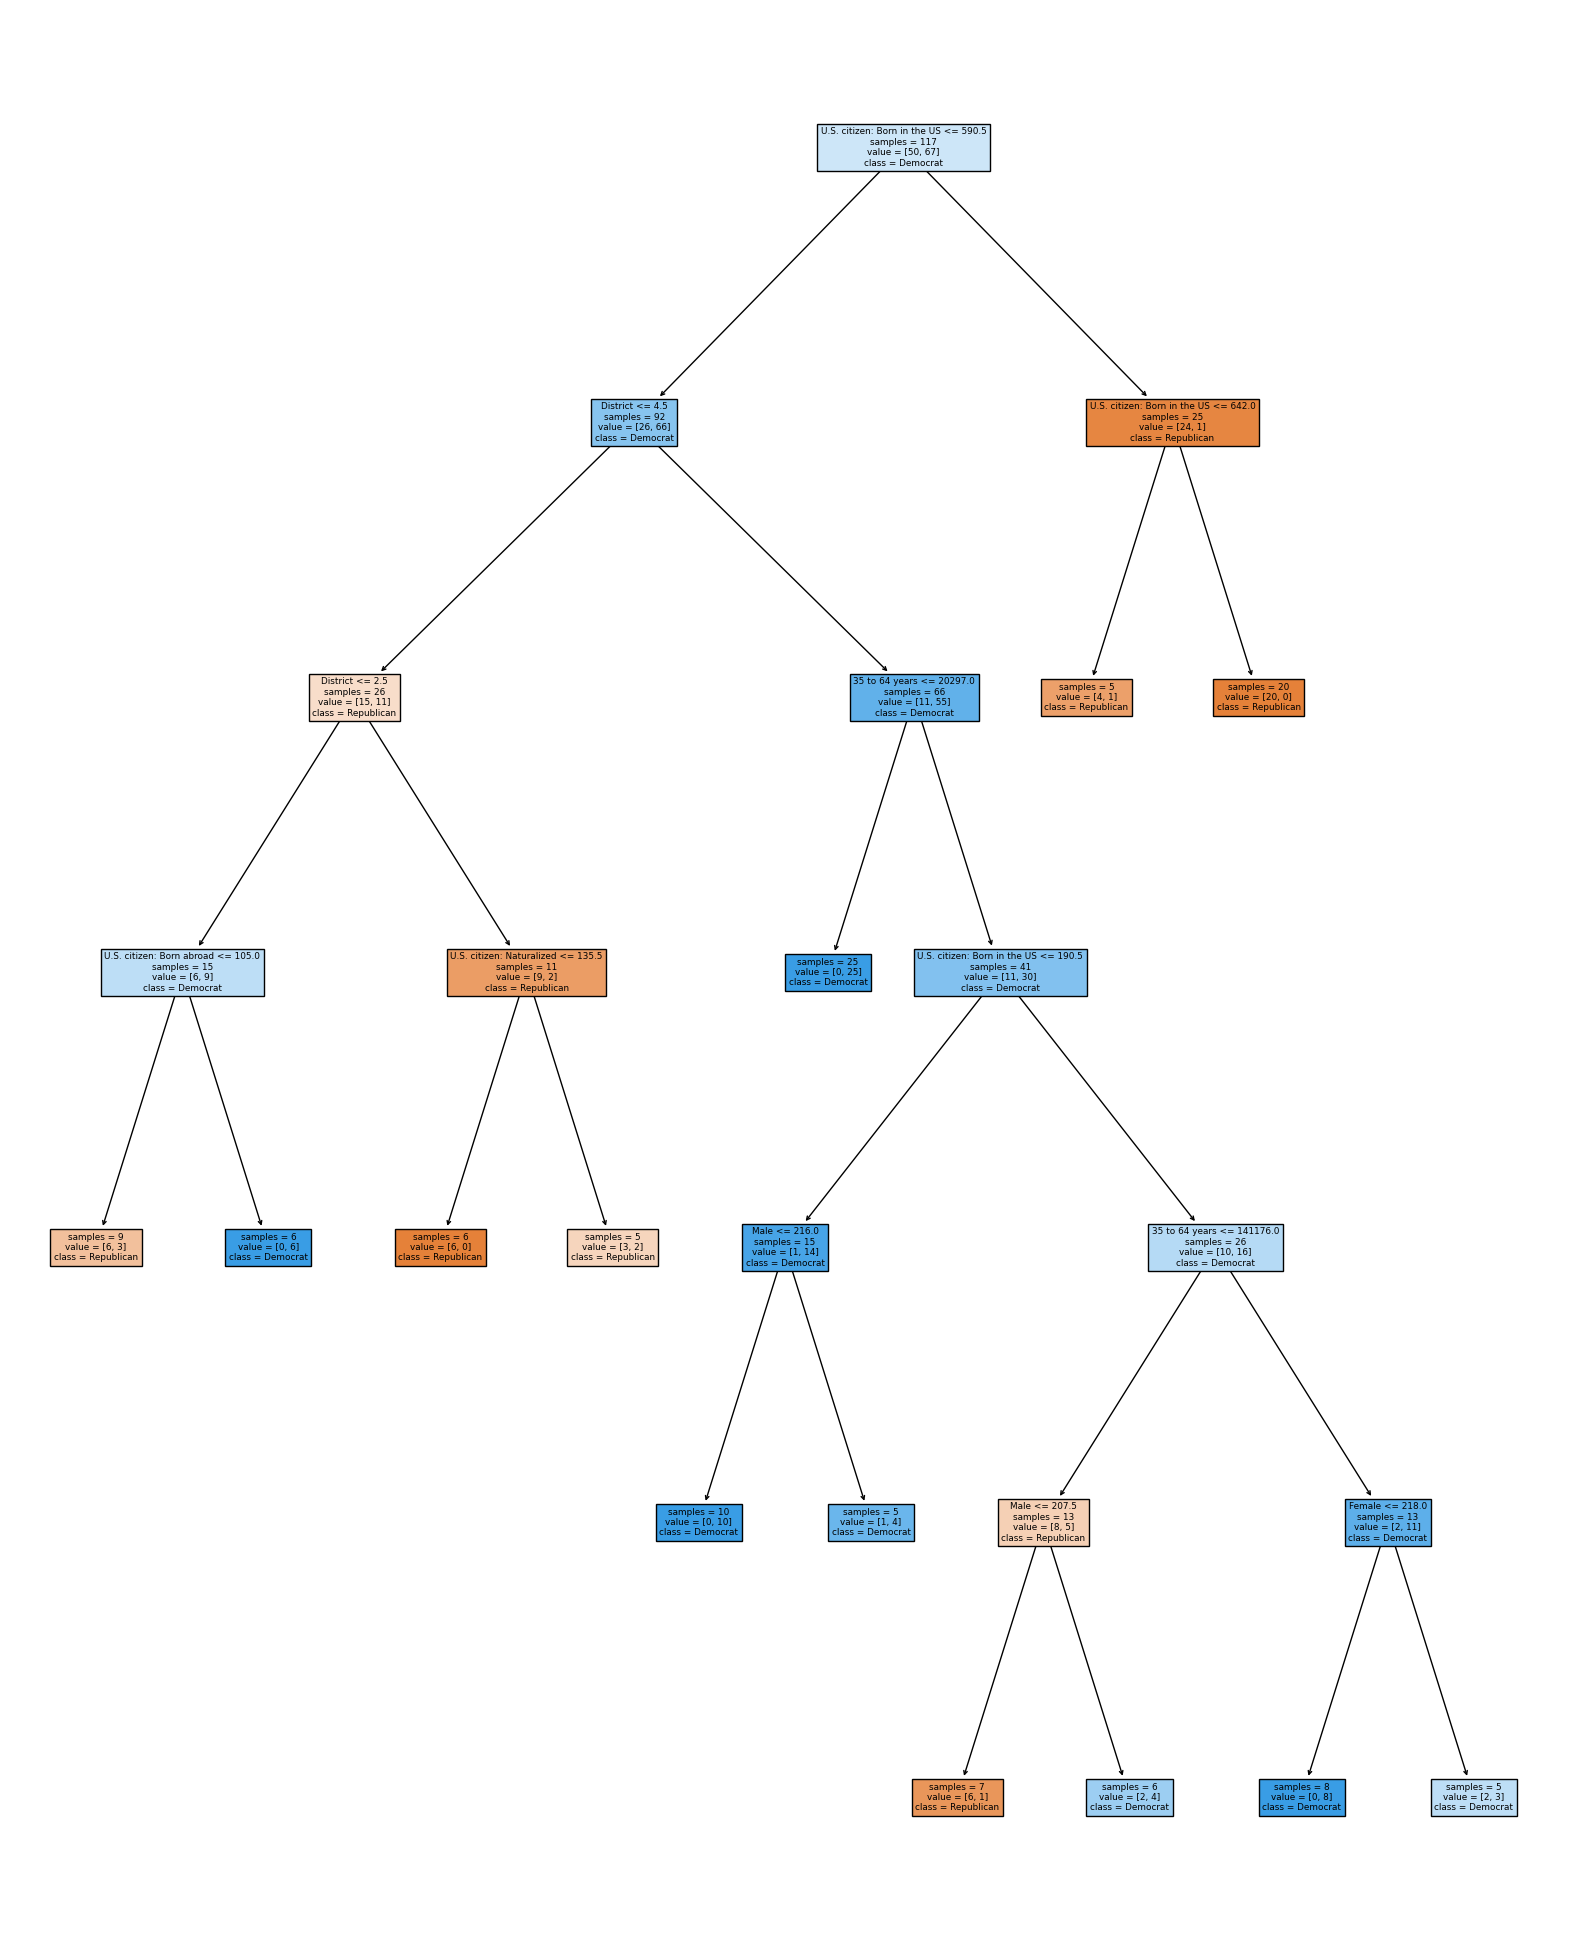

Accuracy: 0.7857142857142857


In [372]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score


# merge county_data with votes
combined = pd.merge(county_data,winners_2020, left_on='COUNTY', right_on='county_name', how='inner')
combined.drop('county_name', axis=1, inplace=True)

# merge combined with district_data
combined = pd.merge(combined, districts, left_on='COUNTY', right_on='County', how='inner')

# convert county names to uppercase and sort
combined['COUNTY'] = combined['COUNTY'].str.upper()
combined = combined.sort_values(by='COUNTY', ascending=True)

# Reset index - chat
combined = combined.reset_index(drop=False)

#print(combined)

# Save to CSV
combined.to_csv('combined.csv', index=False)


selected_features = ['District','U.S. citizen: Born in the US', 'U.S. citizen: Born abroad', 'U.S. citizen: Naturalized', 'Male', 'Female', '18 to 30 years', '35 to 64 years', '65 to 74 years', '75 years and over']
target_variable = 'party'

# Filter dataset to include only selected features and target variable
trainData = combined[selected_features + [target_variable]]
trainData.dropna(inplace=True)
X = trainData[selected_features]
y = trainData[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
clf = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=42)
clf.fit(X_train, y_train)


plt.figure(figsize=(20, 25))
plot_tree(clf, filled=True, feature_names=selected_features, class_names= ['Republican', 'Democrat'], impurity=False)
plt.show()


y_pred = clf.predict(X_test)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Our predictive algorithm combines demographic data and voting district information from the 2020 Virginia elections. By incorporating both demographic characteristics and political geography, the model aims to provide a comprehensive understanding of election outcomes. The predictive algorithm is intended to be tested on demographic data from 2024, enabling it to possible predict the outcome of the 2024 Virginia elections. With the potential similarity to the 2020 election, where Biden and Trump were key contenders, the model can offer insights into the potential outcomes of this rematch.

Demographic data used in the model include citizenship status, gender, and age distribution within counties. These variables are known to influence voting behavior and are therefore crucial for understanding electoral outcomes. The decision nodes in our model analyze demographic thresholds within counties, such as the proportion of citizens in different age groups or gender categories. Based on these thresholds, the model then considers the voting district to further refine predictions.

After fine-tuning the dataset and refining the model parameters, our predictive algorithm achieved an accuracy of 78.57%. This accuracy level demonstrates the effectiveness of the model in capturing the complex interplay between demographics and electoral outcomes. Citizenship status, age distribution, and gender composition can significantly affect voting behavior in Virginia. For example, citizenship status may influence attitudes towards immigration policies, while age demographics can reflect generational differences in political preferences.